# 우산 재배치 시 적정 수량 예측 머신러닝

* 지도학습의 회귀분석(Regression)
    * ex) 해당 날짜 잠실역에 위치한 공유우산함들의 우산 대여, 반납 갯수, 다음날 배치 우산 개수로 최적의 배치 우산 갯수를 예측하기.

In [13]:
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [14]:
import pandas as pd
import numpy as np

file_path = '동승하차_지하철.csv'
data = pd.read_csv(file_path)

data['총유동인구'] = data['출근_승차'] + data['출근_하차'] + data['퇴근_승차'] + data['퇴근_하차']

top_30_stations = data.nlargest(30, '총유동인구')[['호선', '역명', '총유동인구']]

np.random.seed(42)

date_range = pd.date_range(start='2023-07-01', end='2023-07-31', freq='D')

# 우산 반출 및 유입 데이터 생성
umbrella_data = []

for _, row in top_30_stations.iterrows():
    station = row['역명']
    total_traffic = row['총유동인구']
    
    for date in date_range:
        outflow = int(np.random.normal(total_traffic * 0.005, total_traffic * 0.001))
        inflow = int(np.random.normal(total_traffic * 0.005, total_traffic * 0.001))
        umbrella_data.append([station, date, max(outflow, 0), max(inflow, 0)])

umbrella_df = pd.DataFrame(umbrella_data, columns=['역명', '날짜', '우산_반출', '우산_유입'])

umbrella_df.to_csv('behind.csv', index=False)

print(umbrella_df.head())


         역명         날짜   우산_반출   우산_유입
0  잠실(송파구청) 2023-07-01  107133   94757
1  잠실(송파구청) 2023-07-02  110076  127136
2  잠실(송파구청) 2023-07-03   92888   92888
3  잠실(송파구청) 2023-07-04  128231  112409
4  잠실(송파구청) 2023-07-05   88302  108027


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

data = pd.read_csv('Optimized_Umbrella_Data.csv')

data['날짜'] = pd.to_datetime(data['날짜'])

data['year'] = data['날짜'].dt.year
data['month'] = data['날짜'].dt.month
data['day'] = data['날짜'].dt.day
data['dayofweek'] = data['날짜'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', '오늘_배치_우산_개수', '우산_대여', '우산_반납']
target = '내일_배치_우산_개수'

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, R²: {rf_r2}")

xgb_model = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost - MAE: {xgb_mae}, MSE: {xgb_mse}, R²: {xgb_r2}")

Random Forest - MAE: 3754.9993548387097, MSE: 36299609.57947527, R²: 0.9423081056276623
XGBoost - MAE: 4157.6919102822585, MSE: 40785835.03759946, R²: 0.9351780332037721


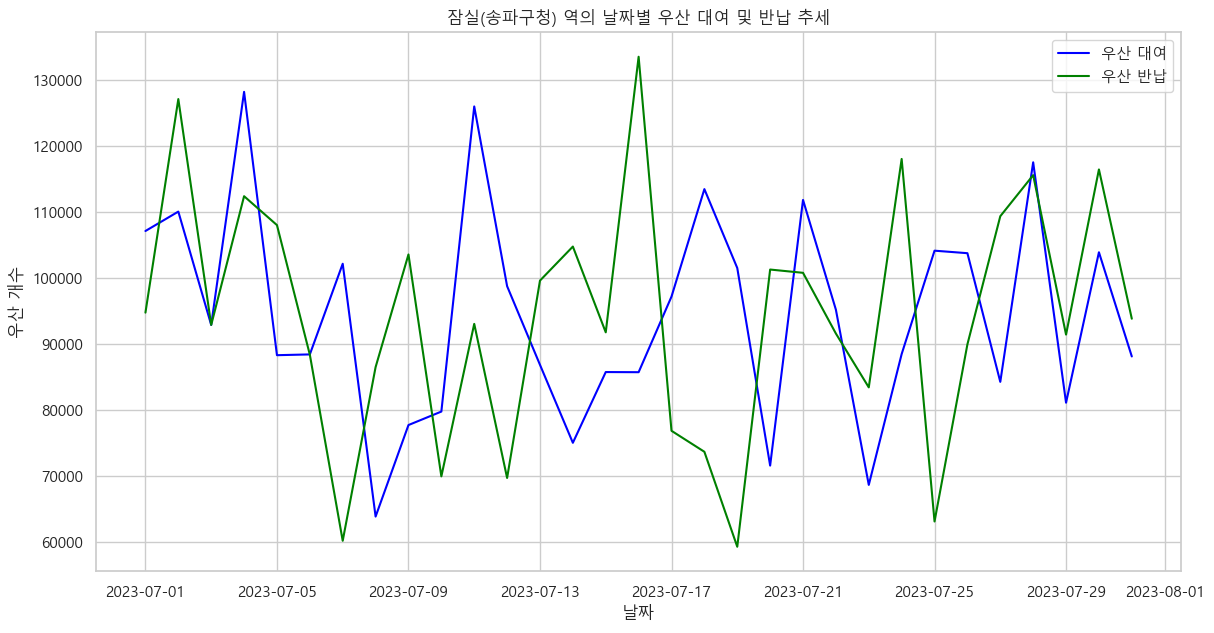

In [16]:
import matplotlib.pyplot as plt

data = pd.read_csv('Optimized_Umbrella_Data.csv')

data['날짜'] = pd.to_datetime(data['날짜'])

specific_station = '잠실(송파구청)'
station_data = data[data['역명'] == specific_station]

plt.figure(figsize=(14, 7))
plt.plot(station_data['날짜'], station_data['우산_대여'], label='우산 대여', color='blue')
plt.plot(station_data['날짜'], station_data['우산_반납'], label='우산 반납', color='green')
plt.xlabel('날짜')
plt.ylabel('우산 개수')
plt.title(f'{specific_station} 역의 날짜별 우산 대여 및 반납 추세')
plt.legend()
plt.show()


## 얻어낼 수 있는점

1. 대여 및 반납 추세 분석
* 우산 대여 추세: 파란색 선으로 표시된 '우산 대여' 그래프는 특정 기간 동안 대여된 우산의 개수를 보여줍니다. 이 추세를 통해 대여량이 증가하거나 감소하는 시점을 파악할 수 있습니다.
* 우산 반납 추세: 녹색 선으로 표시된 '우산 반납' 그래프는 특정 기간 동안 반납된 우산의 개수를 보여줍니다. 이 추세를 통해 반납량이 증가하거나 감소하는 시점을 파악할 수 있습니다.
2. 피크 시점 식별
* 최대 대여 및 반납 시점: 그래프의 피크(peak) 부분을 통해 대여량과 반납량이 가장 많았던 시점을 확인할 수 있습니다. 예를 들어, 특정 날짜에 우산 대여량이 급증한 경우, 그 날짜에 특별한 이벤트가 있었는지 확인할 수 있습니다.
3. 수요와 공급의 균형 확인
* 대여와 반납의 균형: 대여량과 반납량을 비교함으로써, 우산의 수요와 공급이 균형을 이루고 있는지 확인할 수 있습니다. 만약 대여량이 지속적으로 반납량을 초과한다면, 해당 역에서 우산 부족 현상이 발생할 가능성이 있습니다.